# DEEP ADAPTATION NETWORK USING MK-MMD
### Modified from: [[pumpikano](https://github.com/pumpikano/tf-dann), [sjchoi86](https://github.com/sjchoi86/advanced-tensorflow/blob/master/dann/dann_mnist.ipynb)]

### Disclaimer:
- This code does not improve the performance of domain adaptaion.
- It's just a simple example of how MMD loss can be applied to Deep Neural Network

## LOAD PACKAGES

In [1]:
import os
import urllib
import tarfile
import _pickle as pkl # use cPickle for python 2.x
from functools import partial

import numpy as np
import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops
from tensorflow.examples.tutorials.mnist import input_data

import skimage
import skimage.io
import skimage.transform
from scipy.optimize import minimize

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]="0" 

print("PACKAGES ARE LOADED")

PACKAGES ARE LOADED


## DOWNLOAD BSR_bsds500.tgz

In [2]:
filelink = 'http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'
filename = 'data/BSR_bsds500.tgz'
if not os.path.isdir('data'):
    os.mkdir('data')
if os.path.isfile(filename):
    print("[%s] ALREADY EXISTS." % (filename))
else:
    print("DOWNLOADING %s ..." % (filename))
    urllib.request.urlretrieve(filelink, filename)
    print("DONE")

[data/BSR_bsds500.tgz] ALREADY EXISTS.


## CREATE MNIST-M

### HELPER FUNCTIONS

In [3]:
def compose_image(digit, background):
    """Difference-blend a digit and a random patch from a background imgae"""
    w, h, _ = background.shape
    dw, dh, _ = digit.shape
    x = np.random.randint(0, w - dw)
    y = np.random.randint(0, h - dh)
    bg = background[x:x+dw, y:y+dh] # Get center image from background
    return np.abs(bg - digit).astype(np.uint8)
def mnist_to_img(x):
    """Binarize MNIST digit and convert to RGB"""
    x = (x > 0).astype(np.float32)
    d = x.reshape([28, 28, 1]) * 255
    return np.concatenate([d, d, d], 2)
def create_mnistm(X):
    """
    Give an array of MNIST digits, blend random background patches to
    build the MNIST-M dataset as described in
    http://jmlr.org/papers/volume17/15-239/15-239.pdf"""
    X_ = np.zeros([X.shape[0], 28, 28, 3], np.uint8)
    for i in range(X.shape[0]):
        bg_img = rand.choice(background_data)
        d = mnist_to_img(X[i])
        d = compose_image(d, bg_img)
        X_[i] = d
    return X_
print("FUNCTIONS ARE READY")

FUNCTIONS ARE READY


### CREATE MNIST-M DATASET (IF NECESSARY)

In [4]:
mnistm_name = 'data/mnistm.pkl'
if os.path.isfile(mnistm_name):
    print("[%s] ALREADY EXISTS. " % (mnistm_name))
else:
    mnist = input_data.read_data_sets('data')
    # OPEN BSD500
    f = tarfile.open(filename)
    train_files = []
    for name in f.getnames():
        if name.startswith('BSR/BSDS500/data/images/train/'):
            train_files.append(name)
    print("WE HAVE [%d] TRAIN FILES" % (len(train_files)))
    # GET BACKGROUND
    print("GET BACKGROUND FOR MNIST-M")
    background_data = []
    for name in train_files:
        try:
            fp = f.extractfile(name)
            bg_img = skimage.io.imread(fp)
            background_data.append(bg_img)
        except:
            continue
    print("WE HAVE [%d] BACKGROUND DATA" % (len(background_data)))
    rand = np.random.RandomState(42)
    print("BUILDING TRAIN SET...")
    train = create_mnistm(mnist.train.images)
    print("BUILDING TEST SET...")
    test = create_mnistm(mnist.test.images)
    print("BUILDING VALIDATION SET...")
    valid = create_mnistm(mnist.validation.images)
    # SAVE
    print("SAVE MNISTM DATA TO %s" % (mnistm_name))
    with open(mnistm_name, 'wb') as f:
        pkl.dump({'train': train, 'test': test, 'valid': valid}, f, -1)
    print("DONE")

[data/mnistm.pkl] ALREADY EXISTS. 


## LOAD MNIST AND MNIST-M

In [5]:
print("LOADING MNIST")
mnist = input_data.read_data_sets('data', one_hot=True)
mnist_train = (mnist.train.images > 0).reshape(55000, 28, 28, 1).astype(np.uint8) * 255
mnist_train = np.concatenate([mnist_train, mnist_train, mnist_train], 3)
mnist_test = (mnist.test.images > 0).reshape(10000, 28, 28, 1).astype(np.uint8) * 255
mnist_test = np.concatenate([mnist_test, mnist_test, mnist_test], 3)
mnist_train_label = mnist.train.labels
mnist_test_label = mnist.test.labels
print("LOADING MNIST-M")
mnistm_name = 'data/mnistm.pkl'
mnistm = pkl.load(open(mnistm_name, 'rb'))
mnistm_train = mnistm['train']
mnistm_test = mnistm['test']
mnistm_valid = mnistm['valid']
mnistm_train_label = mnist_train_label
mnistm_test_label = mnist_test_label
print("GENERATING DOMAIN DATA")

LOADING MNIST
Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz
LOADING MNIST-M
GENERATING DOMAIN DATA


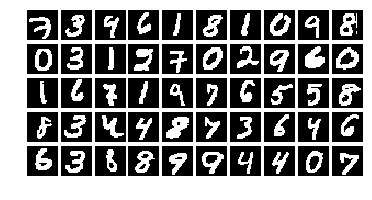

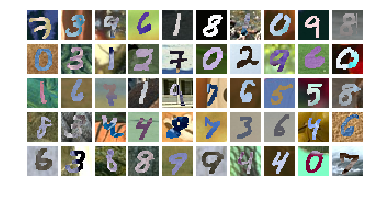

In [6]:
total_train = np.vstack([mnist_train, mnistm_train])
total_test = np.vstack([mnist_test, mnistm_test])
ntrain = mnist_train.shape[0]
ntest = mnist_test.shape[0]
total_train_domain = np.vstack([np.tile([1., 0.], [ntrain, 1]), np.tile([0., 1.], [ntrain, 1])])
total_test_domain = np.vstack([np.tile([1., 0.], [ntest, 1]), np.tile([0., 1.], [ntest, 1])])
n_total_train = total_train.shape[0]
n_total_test = total_test.shape[0]

# GET PIXEL MEAN
pixel_mean_source = mnist_train.mean((0, 1, 2))
pixel_mean_target = mnistm_train.mean((0, 1, 2))
pixel_mean = np.vstack([mnist_train, mnistm_train]).mean((0, 1, 2))

# PLOT IMAGES
def imshow_grid(images, shape=[2, 8]):
    from mpl_toolkits.axes_grid1 import ImageGrid
    fig = plt.figure()
    grid = ImageGrid(fig, 111, nrows_ncols=shape, axes_pad=0.05)
    size = shape[0] * shape[1]
    for i in range(size):
        grid[i].axis('off')
        grid[i].imshow(images[i])
    plt.show()
imshow_grid(mnist_train, shape=[5, 10])
imshow_grid(mnistm_train, shape=[5, 10])

## DEFINE TRAIN / TEST DATA FOR DANN

In [7]:
def print_npshape(x, name):
    print("SHAPE OF %s IS %s" % (name, x.shape,))
# SOURCE AND TARGET DATA
source_train_img = mnist_train
source_train_label = mnist_train_label
source_test_img = mnist_test
source_test_label = mnist_test_label
target_test_img = mnistm_test
target_test_label = mnistm_test_label
# DOMAIN ADVERSARIAL TRAINING
total_train_img = total_train
#total_train_domain

imgshape = source_train_img.shape[1:4]
labelshape = source_train_label.shape[1]

print_npshape(source_train_img, "source_train_img")
print_npshape(source_train_label, "source_train_label")
print_npshape(source_test_img, "source_test_img")
print_npshape(source_test_label, "source_test_label")
print_npshape(target_test_img, "target_test_img")
print_npshape(target_test_label, "target_test_label")
print_npshape(total_train_img, "total_train_img")
print_npshape(total_train_domain, "total_train_label")

print(imgshape)
print(labelshape)

SHAPE OF source_train_img IS (55000, 28, 28, 3)
SHAPE OF source_train_label IS (55000, 10)
SHAPE OF source_test_img IS (10000, 28, 28, 3)
SHAPE OF source_test_label IS (10000, 10)
SHAPE OF target_test_img IS (10000, 28, 28, 3)
SHAPE OF target_test_label IS (10000, 10)
SHAPE OF total_train_img IS (110000, 28, 28, 3)
SHAPE OF total_train_label IS (110000, 2)
(28, 28, 3)
10


## BUILD MODEL

### DEFINE FUNCTIONS FOR NETWORK ARCHITECTURE

In [8]:
# FOR BUILDING NETWORK ARCHITECTURE
# CONV LAYER
def conv_layer(x, name='conv_layer', reuse=False):
    with tf.variable_scope(name) as scope:
        if reuse:
            scope.reuse_variables()
        x = (tf.cast(x, tf.float32) - pixel_mean) / 255.
        conv1 = slim.conv2d(x, 32, [5, 5],
                         weights_regularizer=regularizer, scope='conv1')
        pool1 = slim.max_pool2d(conv1, [2, 2], scope='pool1')
        conv2 = slim.conv2d(pool1, 48, [5, 5],
                         weights_regularizer=regularizer, scope='conv2')
        pool2 = slim.max_pool2d(conv2, [2, 2], scope='pool2')
        feat = slim.flatten(pool2, scope='flat')
    ret = {'conv1': conv1, 'pool1': pool1, 'conv2': conv2, 'pool2': pool2, 'feat': feat}
    return ret

# FULLY CONNECTED LAYER
def fc_layer(feat, name='fc_layer', reuse=False):
    with tf.variable_scope(name) as scope:
        if reuse:
            scope.reuse_variables()
        fc3 = slim.fully_connected(feat, 100, weights_regularizer=regularizer, scope='fc3')
        fc4 = slim.fully_connected(fc3, 100, weights_regularizer=regularizer, scope='fc4')
        out = slim.fully_connected(fc4, 10, activation_fn=None,
                                  weights_regularizer=regularizer, scope='out')
    ret = {'fc3': fc3, 'fc4': fc4, 'out': out}
    return ret

### BUILD NETWORK

In [9]:
xs = tf.placeholder(tf.uint8, [None, imgshape[0], imgshape[1], imgshape[2]])
ys = tf.placeholder(tf.float32, [None, labelshape])
xt = tf.placeholder(tf.uint8, [None, imgshape[0], imgshape[1], imgshape[2]])
yt = tf.placeholder(tf.float32, [None, labelshape])

beta3 = tf.placeholder(tf.float32, [None])
beta4 = tf.placeholder(tf.float32, [None])
d = tf.placeholder(tf.float32, [None, 2]) # DOMAIN LABEL
lr = tf.placeholder(tf.float32, [])
dw = tf.placeholder(tf.float32, [])

regularizer = slim.l2_regularizer(0.005)

# DOMAIN ADAPTATION NETWORK (DAN)
feat_conv_dan_s = conv_layer(xs, name='dan_conv_layer')['feat']
fc_dan_s = fc_layer(feat_conv_dan_s, name='dan_fc_layer')

feat_conv_dan_t = conv_layer(xt, name='dan_conv_layer', reuse=True)['feat']
fc_dan_t = fc_layer(feat_conv_dan_t, name='dan_fc_layer', reuse=True)

# BASELINE NETWORK
feat_conv_base = conv_layer(xs, name='base_conv_layer')['feat']
fc_base = fc_layer(feat_conv_base, name='base_fc_conv')

print("NETWORK IS READY")

NETWORK IS READY


### CHECK VARIABLES

In [10]:
t_weights = tf.trainable_variables()
# FEATURE EXTRACTOR + CLASS PREDICTOR
print("WEIGHT LIST FOR DAN NETWORK")
for i in range(len(t_weights)):
    if t_weights[i].name[:3] == 'dan':
        print("[%s] shape=%s" % (t_weights[i].name, t_weights[i].get_shape()))

print("\nWEIGHT LIST FOR BASE NETWORK")
for i in range(len(t_weights)):
    if t_weights[i].name[:4] == 'base':
        print("[%s] shape=%s" % (t_weights[i].name, t_weights[i].get_shape()))

WEIGHT LIST FOR DAN NETWORK
[dan_conv_layer/conv1/weights:0] shape=(5, 5, 3, 32)
[dan_conv_layer/conv1/biases:0] shape=(32,)
[dan_conv_layer/conv2/weights:0] shape=(5, 5, 32, 48)
[dan_conv_layer/conv2/biases:0] shape=(48,)
[dan_fc_layer/fc3/weights:0] shape=(2352, 100)
[dan_fc_layer/fc3/biases:0] shape=(100,)
[dan_fc_layer/fc4/weights:0] shape=(100, 100)
[dan_fc_layer/fc4/biases:0] shape=(100,)
[dan_fc_layer/out/weights:0] shape=(100, 10)
[dan_fc_layer/out/biases:0] shape=(10,)

WEIGHT LIST FOR BASE NETWORK
[base_conv_layer/conv1/weights:0] shape=(5, 5, 3, 32)
[base_conv_layer/conv1/biases:0] shape=(32,)
[base_conv_layer/conv2/weights:0] shape=(5, 5, 32, 48)
[base_conv_layer/conv2/biases:0] shape=(48,)
[base_fc_conv/fc3/weights:0] shape=(2352, 100)
[base_fc_conv/fc3/biases:0] shape=(100,)
[base_fc_conv/fc4/weights:0] shape=(100, 100)
[base_fc_conv/fc4/biases:0] shape=(100,)
[base_fc_conv/out/weights:0] shape=(100, 10)
[base_fc_conv/out/biases:0] shape=(10,)


### DEFINE FUNCTIONS FOR MMD LOSS

In [11]:
def generate_rbf_kernels(number=10):
    hyps = []
    for i in range(number):
        hyps.append({'sig2f': 1., 'sig2l': 2**(-4+i)})
    kernels = list(map(lambda h: partial(lambda hyp,x1,x2: kernel_rbf_elem(x1,x2,hyp), h), hyps))
    coeffs = np.ones(len(hyps), dtype=np.float32) / len(hyps)
    
    return kernels, coeffs


def kernel_rbf_elem(x1, x2, hyp):
    """
    compute kernel vector kvect where kvect[i] = k(x1[i], x2[i])
    Args:
        x1: nbatch x dim_x (tf_tensor)
        x2: nbatch x dim_x (tf_tensor)
        hyp: dictionary {sig2f, sig2l, sig2w}
    Output:
        kernel vector of size [nbatch] (tf_tensor)
    """
    sig2f = hyp['sig2f']
    sig2l = hyp['sig2l']
    kvect = sig2f * tf.exp(-tf.reduce_sum(tf.square(x1 - x2)/sig2l, axis=[1]))
    return kvect

def kernel_rbf_pairwise(x1, x2, hyp):
    """
    compute kernel matrix
    Args:
        x1: nbatch1 x dim_x (tf_tensor)
        x2: nbatch2 x dim_x (tf_tensor)
        hyp: dictionary {sig2f, sig2l, sig2w}
    Output:
        kernel matrix : nbatch1 x nbatch2 (tf_tensor)
    """
    sig2f = hyp['sig2f']
    sig2l = hyp['sig2l']
    diffmat = tf.einsum('ik,jk->ijk', x1, -x2)
    pdist2 = tf.reduce_sum(tf.square(diffmat), axis=[2])
    kernelmat = sig2f * tf.exp(-pdist2/sig2l)
    return kernelmat

def mmd_est_linear(x1, x2, kfunc):
    """
    compute linear-time MMD estimator
    Args:
        x1: nbatch x dim_x (tf_tensor)
        x2: nbatch x dim_x (tf_tensor)
        kfunc: kernel function, argument: x1, x2
    Output:
        linear time mmd_estimate: (tf_scalar)
    """
    nbatch1 = x1.shape.as_list()[0]
    nbatch2 = x2.shape.as_list()[0]
    if nbatch1 is not nbatch2:
        raise ValueError('batch size doesn''t match: n1={}, n2={}'.format(nbatch1, nbatch2))
    x1odd = x1[::2]
    x1even = x1[1::2]
    x2odd = x2[::2]
    x2even = x2[1::2]

    return kfunc(x1odd, x1even) + kfunc(x2odd, x2even) \
         - kfunc(x1odd, x2even) - kfunc(x1even, x2odd)

def mmd_est_linear_vect(x1, x2, kfuncs):
    """
    compute mk-mmd vector
    Args:
        kfuncs: list of multiple kernel functions
    """
    nfunc = len(kfuncs)
    gvect = tf.concat([tf.expand_dims(mmd_est_linear(x1, x2, kfunc), axis=1) for kfunc in kfuncs], axis=1)

    return gvect

def mmd_est_linear_cov(x1, x2, kfuncs):
    """
    compute covariance matrix of mmd_est_linear
    Args:
        kfuncs: list of multiple kernel functions
    Outputs: matrix of mmd_est_linear_cov,
             num_kfuncs x num_kfuncs (tf_tensor)
    """
    x1odd = x1[::2]
    x1even = x1[1::2]
    x2odd = x2[::2]
    x2even = x2[1::2]

    gdelta_vect = mmd_est_linear_vect(x1odd, x2odd, kfuncs) \
                - mmd_est_linear_vect(x1even, x2even, kfuncs)
    Qmat = tf.reduce_mean(
          tf.einsum('ij,ik->ijk', gdelta_vect, gdelta_vect), axis=0)
    
    return Qmat

def mkmmd(x1, x2, coeffs, kfuncs):
    gvect = mmd_est_linear_vect(x1, x2, kfuncs)
    Qmat = mmd_est_linear_cov(x1, x2, kfuncs)
    return tf.reduce_sum(coeffs * tf.reduce_mean(gvect, axis=0)), \
            Qmat, \
            gvect

    
# functions for QP optimization
def opt_obj(beta, Q, sign=1.0, eps=1E-3):
    val = np.squeeze(
          sign*np.matmul(beta, np.matmul((Q+eps*np.eye(Q.shape[0])), np.expand_dims(beta, 1))),
          axis=0)
    return val

def opt_deriv(beta, Q, sign=1.0, eps=1E-3):
    eps = 1E-3
    dfdb = sign*np.matmul(beta, Q + np.transpose(Q) + 2*eps*np.eye(Q.shape[0]))
    return dfdb

def optimize_mkmmd_coeffs(beta, eta, Q, verbose=True):
    eps = 1E-3
    cons = ({'type': 'eq',
             'fun': lambda x: np.matmul(x, eta) - 1,
             'jac': lambda x: eta}, 
            {'type': 'ineq',
             'fun': lambda x: x,
             'jac': lambda x: np.eye(len(x))})
    res = minimize(opt_obj, beta,
                   args=(Q, 1.0, eps), 
                   jac=opt_deriv,
                   constraints=cons,
                   method='SLSQP',
                   options={'disp': False})
    beta_new = res.x / sum(res.x)
    if verbose:
        print('        beta: {}'.format(beta_new))
    return np.asarray(beta_new, dtype=np.float32)

print("FUNCTIONS ARE READY")

FUNCTIONS ARE READY


### DEFINE LOSSES

In [12]:
# LOSSES FOR DAN
# MK-MMD LOSS
num_kernels = 10

k_coeffs_fc3 = tf.placeholder(tf.float32, [num_kernels])
k_coeffs_fc4 = tf.placeholder(tf.float32, [num_kernels])
kfuncs_fc3, k_coeffs_fc3_np = generate_rbf_kernels(num_kernels)
kfuncs_fc4, k_coeffs_fc4_np = generate_rbf_kernels(num_kernels)
mkmmd_loss_fc3, mkmmd_Q_fc3, mkmmd_g_fc3 = mkmmd(fc_dan_s['fc3'], fc_dan_t['fc3'], k_coeffs_fc3, kfuncs_fc3)
mkmmd_loss_fc4, mkmmd_Q_fc4, mkmmd_g_fc4 = mkmmd(fc_dan_s['fc4'], fc_dan_t['fc4'], k_coeffs_fc4, kfuncs_fc4)


lamb = 1E2 # coeff for mkmmd loss

class_pred_dan_s = fc_dan_s['out']
class_loss_dan_s = tf.losses.softmax_cross_entropy(onehot_labels=ys, logits=class_pred_dan_s)

reg_loss_list = tf.losses.get_regularization_losses()
reg_loss_dan = tf.add_n([loss for loss in reg_loss_list if loss.name.startswith('dan')])

class_loss_dan = class_loss_dan_s + reg_loss_dan
total_loss_dan = class_loss_dan_s + lamb * (mkmmd_loss_fc3 + mkmmd_loss_fc4) + reg_loss_dan

optm_class_dan = tf.train.AdamOptimizer(0.001).minimize(class_loss_dan)
optm_total_dan = tf.train.MomentumOptimizer(lr, 0.9).minimize(total_loss_dan)

accr_class_dan_s = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(class_pred_dan_s, 1), tf.arg_max(ys, 1)), tf.float32))



# LOSSES FOR BASELINE
class_pred_base = fc_base['out']
reg_loss_base = tf.add_n([loss for loss in reg_loss_list if loss.name.startswith('base')])
class_loss_base = tf.losses.softmax_cross_entropy(onehot_labels=ys, logits=class_pred_base)
total_loss_base = class_loss_base + reg_loss_base # + l2_weight loss?

adam_total_base = tf.train.AdamOptimizer(0.001).minimize(total_loss_base)
optm_total_base = tf.train.MomentumOptimizer(lr, 0.9).minimize(total_loss_base)
# optm_total_base = tf.train.AdamOptimizer(lr).minimize(total_loss_base)

accr_class_base = tf.reduce_mean(tf.cast(tf.equal(tf.arg_max(class_pred_base, 1), tf.arg_max(ys, 1)), tf.float32))

print("LOSSES ARE READY")        

LOSSES ARE READY


## OPEN SESSION

In [13]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

tf.set_random_seed(0)
init = tf.global_variables_initializer()

sess.run(init)

print("SESSION IS OPENED")

SESSION IS OPENED


## OPTIMIZE

In [14]:
# PARAMETERS
batch_size      = 128
training_epochs = 40
pre_epochs = 3
every_mkmmd = ntrain // batch_size

every_epoch     = 1
num_batch = ntrain // batch_size
total_iter = training_epochs*num_batch

for epoch in range(training_epochs):
    randpermlist_s = np.random.permutation(ntrain)
    randpermlist_t = np.random.permutation(ntrain)
        
    for i in range(num_batch): 
        # REVERSAL WEIGHT AND LEARNING RATE SCHEDULE
        curriter = epoch*num_batch + i
        p        = float(curriter) / float(total_iter)
#         lr_val   = (1/max(1,lamb)) * 1.0 * 0.01 / (1. + 10 * p)**0.75
        lr_val   = (1/max(1,lamb)) * 1.0 * 0.1 / (1. + 4 * p)**0.75
#         lr_val = (1/max(1,lamb)) * 1.0 * 0.1
        
        randidx_s = randpermlist_s[i*batch_size:min((i+1)*batch_size, ntrain)]
        randidx_t = randpermlist_t[i*batch_size:min((i+1)*batch_size, ntrain)]
        
        batch_xs = mnist_train[randidx_s]
        batch_ys = mnist_train_label[randidx_s].astype(np.uint8)
        
        batch_xt = mnistm_train[randidx_t]
        
        if epoch < pre_epochs:
            _, _, lossval_dan, lossval_base = sess.run([optm_class_dan, adam_total_base, class_loss_dan, total_loss_base],
                                                      feed_dict = {xs: batch_xs, ys: batch_ys})
        else:
            feed_batch = {xs: batch_xs, ys: batch_ys, xt: batch_xt, lr: lr_val,
                          k_coeffs_fc3: k_coeffs_fc3_np, k_coeffs_fc4: k_coeffs_fc4_np}
            
            _, _, lossval_dan, lossval_base, \
            Q3_np, Q4_np, g3_np, g4_np \
            = sess.run([optm_total_dan, optm_total_base, total_loss_dan, total_loss_base,
                        mkmmd_Q_fc3, mkmmd_Q_fc4, mkmmd_g_fc3, mkmmd_g_fc4],
                        feed_dict=feed_batch)
            
            eta3_np = np.mean(g3_np, 0)
            eta4_np = np.mean(g3_np, 0)
            
            if i % every_mkmmd == 0:
                Q3_cum = np.expand_dims(Q3_np, 0)
                Q4_cum = np.expand_dims(Q4_np, 0)
                eta3_cum = np.expand_dims(eta3_np, 0)
                eta4_cum = np.expand_dims(eta4_np, 0)
            else:
                Q3_cum = np.concatenate([Q3_cum, np.expand_dims(Q3_np, 0)], axis=0)
                Q4_cum = np.concatenate([Q4_cum, np.expand_dims(Q4_np, 0)], axis=0)
                eta3_cum = np.concatenate([eta3_cum, np.expand_dims(eta3_np, 0)], axis=0)
                eta4_cum = np.concatenate([eta4_cum, np.expand_dims(eta4_np, 0)], axis=0)

            if i % every_mkmmd == every_mkmmd-1:
                Q3_mean = np.mean(Q3_cum, 0)
                Q4_mean = np.mean(Q4_cum, 0)
                eta3_mean = np.mean(eta3_cum, 0)
                eta4_mean = np.mean(eta4_cum, 0)
                
                k_coeffs_fc3_np = optimize_mkmmd_coeffs(k_coeffs_fc3_np, eta3_mean, Q3_mean, verbose=False)
                k_coeffs_fc4_np = optimize_mkmmd_coeffs(k_coeffs_fc4_np, eta4_mean, Q4_mean, verbose=False)
        
    if epoch % every_epoch == 0:
        # CHECK BOTH LOSSES
        print ("[%d/%d][%d/%d] lr_val: %.3e lossval_dan: %.3e, lossval_base: %.3e" 
               % (epoch+1, training_epochs, curriter, total_iter, lr_val, lossval_dan, lossval_base))
        
        # CHECK ACCUARACIES OF BOTH SOURCE AND TARGET
        feed_source = {xs: mnist_test, ys: mnist_test_label.astype('uint8')}
        feed_target = {xs: mnistm_test, ys: mnistm_test_label.astype('uint8')}
        accr_source_dan  = sess.run(accr_class_dan_s, feed_dict=feed_source)
        accr_target_dan  = sess.run(accr_class_dan_s, feed_dict=feed_target)
        accr_source_base = sess.run(accr_class_base, feed_dict=feed_source)
        accr_target_base = sess.run(accr_class_base, feed_dict=feed_target)
        
        print (" DAN : SOURCE ACCURACY: %.3f TARGET ACCURACY: %.3f" 
               % (accr_source_dan, accr_target_dan)) 
        print (" BASE: SOURCE ACCURACY: %.3f TARGET ACCURACY: %.3f" 
               % (accr_source_base, accr_target_base))
        print(np.array2string(k_coeffs_fc3_np, formatter={'float': '{: .2e}'.format}))
        print(np.array2string(k_coeffs_fc4_np, formatter={'float': '{: .2e}'.format}))

[1/40][428/17160] lr_val: 9.312e-04 lossval_dan: 3.662e-01, lossval_base: 3.970e-01
 DAN : SOURCE ACCURACY: 0.977 TARGET ACCURACY: 0.570
 BASE: SOURCE ACCURACY: 0.976 TARGET ACCURACY: 0.588
[ 1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01
  1.00e-01  1.00e-01  1.00e-01]
[ 1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01
  1.00e-01  1.00e-01  1.00e-01]
[2/40][857/17160] lr_val: 8.723e-04 lossval_dan: 2.976e-01, lossval_base: 3.084e-01
 DAN : SOURCE ACCURACY: 0.979 TARGET ACCURACY: 0.612
 BASE: SOURCE ACCURACY: 0.979 TARGET ACCURACY: 0.631
[ 1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01
  1.00e-01  1.00e-01  1.00e-01]
[ 1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01  1.00e-01
  1.00e-01  1.00e-01  1.00e-01]
[3/40][1286/17160] lr_val: 8.215e-04 lossval_dan: 2.087e-01, lossval_base: 2.259e-01
 DAN : SOURCE ACCURACY: 0.979 TARGET ACCURACY: 0.604
 BASE: SOURCE ACCURACY: 0.982 TARGET ACCURACY: 0.618
[ 1.00e-01  1.00e

[22/40][9437/17160] lr_val: 4.180e-04 lossval_dan: 2.058e-01, lossval_base: 1.777e-01
 DAN : SOURCE ACCURACY: 0.983 TARGET ACCURACY: 0.406
 BASE: SOURCE ACCURACY: 0.987 TARGET ACCURACY: 0.632
[ 1.00e-16  2.40e-39  4.90e-32  8.45e-35  1.31e-17  3.88e-14  2.01e-07
  8.45e-04  6.23e-02  9.37e-01]
[ 2.01e-16  2.34e-43  4.90e-32  1.48e-20  3.62e-16  2.88e-14  8.44e-08
  7.92e-04  6.13e-02  9.38e-01]
[23/40][9866/17160] lr_val: 4.084e-04 lossval_dan: 2.016e-01, lossval_base: 1.662e-01
 DAN : SOURCE ACCURACY: 0.984 TARGET ACCURACY: 0.403
 BASE: SOURCE ACCURACY: 0.986 TARGET ACCURACY: 0.632
[ 2.16e-16  1.25e-43  2.53e-36  4.37e-39  1.59e-20  9.58e-11  8.66e-06
  3.45e-03  1.04e-01  8.93e-01]
[ 3.22e-16  0.00e+00  8.33e-32  7.35e-25 -3.21e-32  2.32e-26  1.50e-23
  2.25e-03  9.98e-02  8.98e-01]
[24/40][10295/17160] lr_val: 3.994e-04 lossval_dan: 2.426e-01, lossval_base: 1.945e-01
 DAN : SOURCE ACCURACY: 0.985 TARGET ACCURACY: 0.405
 BASE: SOURCE ACCURACY: 0.987 TARGET ACCURACY: 0.632
[ 1.73e-17 

## CHECK WITH T-SNE

In [15]:
# COMBINE SOURCE AND TARGET DATA
num_test = 500
comb_imgs   = np.vstack([source_test_img[:num_test], target_test_img[:num_test]])
comb_labels = np.vstack([source_test_label[:num_test], target_test_label[:num_test]])
comb_domain = np.vstack([np.tile([1., 0.], [num_test, 1]), np.tile([0., 1.], [num_test, 1])])

# GET FEATURE REPRESENTATIONS
test_emb_dann = sess.run(fc_dan_s['fc4'], feed_dict={xs: comb_imgs})
test_emb_cnn = sess.run(fc_base['fc4'], feed_dict={xs: comb_imgs})

# RUN T-SNE
tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=3000)
dann_tsne = tsne.fit_transform(test_emb_dann)
cnn_tsne  = tsne.fit_transform(test_emb_cnn)
print ("T-SNE IS DONE.")

T-SNE IS DONE.


## PLOT FUNCTION

In [16]:
def plot_embedding(X, y, d, title=None):
    """Plot an embedding X with the class label y colored by the domain d."""
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)
    # PLOT COLORED NUMBERS
    plt.figure(figsize=(10, 10)) 
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color = plt.cm.bwr(d[i] / 1.),
                 fontdict={'weight': 'bold', 'size': 9})
    plt.xticks([]), plt.yticks([]) # REMOVE TICKS
    xmean, xvar = np.mean(X, 0), np.var(X, 0)
    if title is not None:
        plt.title(title)

## PLOT REPRESENTATIONS WITH T-SNE

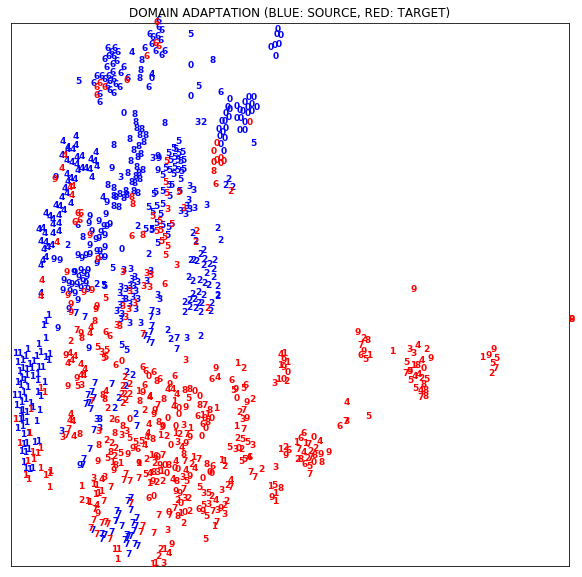

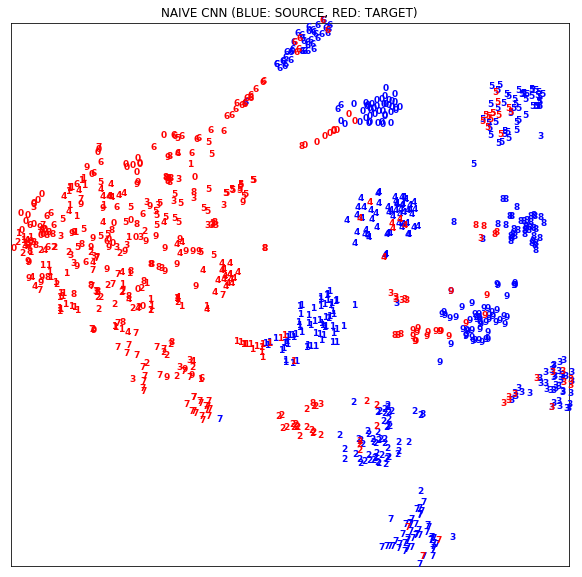

In [17]:
# 0: BLUE (SOURSE) 1: RED (TARGET) 
plot_embedding(dann_tsne, comb_labels.argmax(1), comb_domain.argmax(1)
               , 'DOMAIN ADAPTATION (BLUE: SOURCE, RED: TARGET)')
plot_embedding(cnn_tsne, comb_labels.argmax(1), comb_domain.argmax(1)
               , 'NAIVE CNN (BLUE: SOURCE, RED: TARGET)')

In [18]:
sess.close()